In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


Lazy Predict 라이브러리 : https://lazypredict.readthedocs.io
- Lazy Predict 라이브러리 다운

In [2]:
from IPython.display import clear_output
!pip3 install -U lazypredict
!pip3 install -U pandas 

clear_output()

# Step 1. 라이브러리 및 데이터 불러오기
- 본 프로젝트 수행을 위한 필수 라이브러리를 불러온다. 

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots



from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split


from lightgbm import LGBMClassifier
import lazypredict
from lazypredict.Supervised import LazyClassifier

import time
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


- 버전 확인

In [4]:
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)

print("matplotlib version:", matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 1.20.3
pandas version: 1.3.5
matplotlib version: 3.5.1
seaborn version: 0.11.2


- 이번에는 주어진 데이터를 불러온다. 
- 훈련데이터는 8,693개, 테스트 데이터는 4,277개로 구성이 되어 있음
- 독립변수 컬럼 갯수는 13개이며, 종속 변수는 1개로 구성되어 있음

In [5]:
train_data = pd.read_csv("../input/spaceship-titanic/train.csv")
test_data = pd.read_csv("../input/spaceship-titanic/test.csv")
sample_submission = pd.read_csv("../input/spaceship-titanic/sample_submission.csv")

RANDOM_STATE = 12 
FOLDS = 5
STRATEGY = 'median'

train_data.shape, test_data.shape, sample_submission.shape

((8693, 14), (4277, 13), (4277, 2))

- train_data에 대해 살펴본다. 
- 먼저, 결측치가 있는 코드들이 있지만, 전체적으로 많은 편은 아님. 
- bool(1), float64(6), object(7)개로 구성이 되어 있음. 

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


- 테스트 데이터도 마찬가지로 비슷한 양상을 나타냄. 

In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


- 예측해야 할 종속변수는 Transported 인 것으로 확인됨. 

In [8]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  4277 non-null   object
 1   Transported  4277 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 37.7+ KB


- 데이터 컬럼 확인
    + 각 데이터의 특성을 파악하기 위해서는 해당 설명서를 참조하는 것이 좋음. 
    + 출처 : https://www.kaggle.com/competitions/spaceship-titanic/data
- 본 포스트에서는 추가 설명은 생략함. 

- 대회주제
    + Transported Column 설명을 보면, 다른 차원으로 이동하기 위한, 각 승객의 탑승을 했는지 못했는지를 예측하는 문제이며, 평가지표는 정확도로 판정함.
- 분류 정확도(Classification Accuracy)의 설명은 [Classification Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy)에서 확인할 수 있다. 

# Step 2. 탐색적 자료 분석 (EDA)
- 데이터 시각화
- 산점도, 막대 그래프 등
- 그래프 해석해서 설명을 달아야 함
- 약간의 데이터 전처리

## 데이터 시각화를 위한 주요 함수 작성
- 훈련데이터의 구조는 다음과 같다. 
    + dtypes: bool(1), float64(6), object(7)
- 우선, 종속변수인 bool의 갯수에 대해 확인한다. 
- 갯수로 파악할 때는 비율은 큰 차이가 없는 것으로 확인했다. 즉, 데이터는 매우 균등하게 구성이 된 것이다. 

In [9]:
train_data['Transported'].value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

In [10]:
train_data['CryoSleep'].value_counts()

False    5439
True     3037
Name: CryoSleep, dtype: int64

In [11]:
def cnt_bar(data, col_name):
    df = data[col_name].value_counts()
    fig, ax = plt.subplots(figsize=(10, 8))
    labels = [str(item) for item in list(data[col_name].value_counts().index)]
    bars = sns.countplot(x=col_name, data=data, color='lightgray', alpha=0.85, zorder=2, ax=ax)
    
    for bar in bars.patches:
        fontweight = "normal"
        color = "k"
        height = np.round(bar.get_height(), 2)
        if bar.get_height() == data[col_name].value_counts().values[0]:
            fontweight="bold"
            color="orange"
            bar.set_facecolor(color)
        ax.text(bar.get_x() + bar.get_width()/2., height+100, height+1, ha = 'center', size=12, fontweight=fontweight, color=color)
    ax.set_title(f'Bar Graph of {col_name}', size = 16)
    ax.set_xlabel(col_name, size = 16)
    ax.set_ylabel("No. Passengers", size = 16)

    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_position(("outward", 20))
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.grid(axis="y", which="major", color="lightgray")
    ax.grid(axis="y", which="minor", ls=":")
    
    plt.show()

- 이제 함수를 적용해본다. 
    + Cabin이나, PassengerID 등에는 적용할 수 없다. 

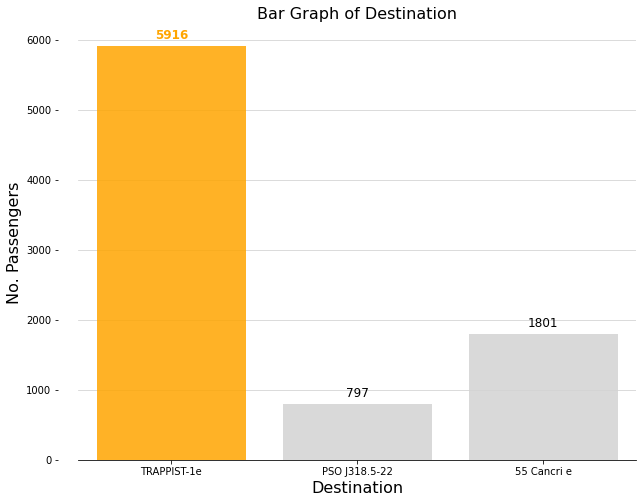

In [12]:
cnt_bar(train_data, "Destination")

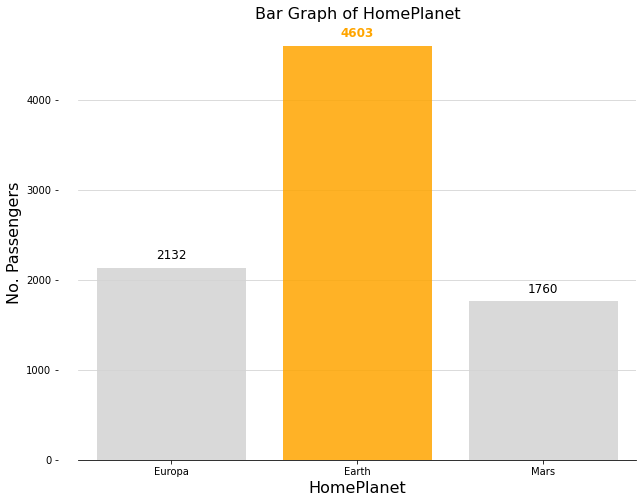

In [13]:
cnt_bar(train_data, "HomePlanet")

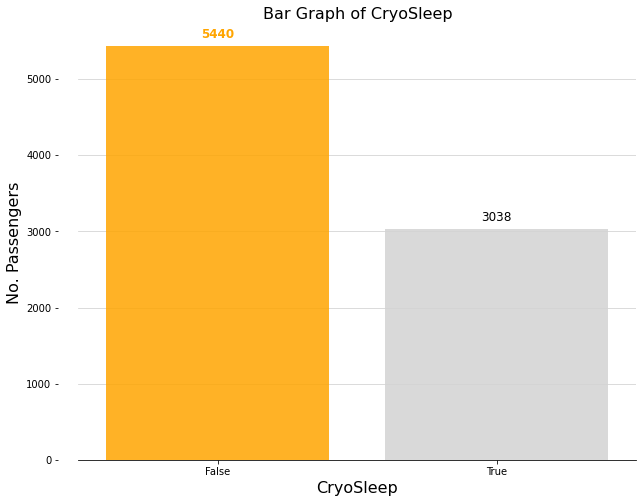

In [14]:
cnt_bar(train_data, "CryoSleep")

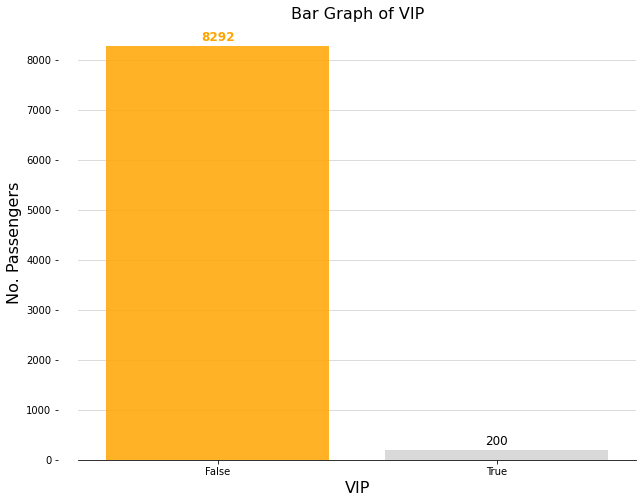

In [15]:
cnt_bar(train_data, "VIP")

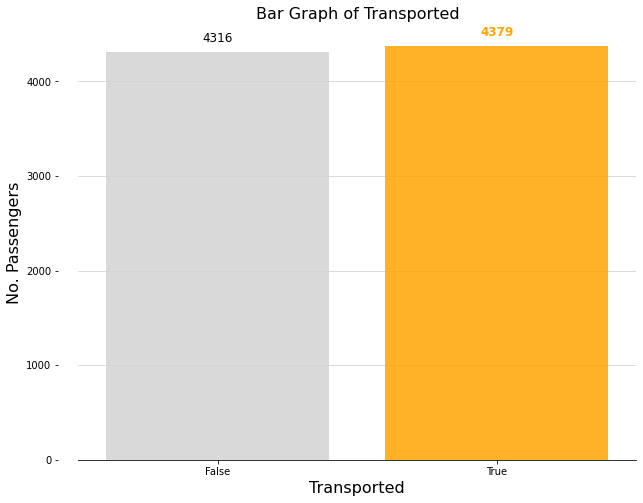

In [16]:
cnt_bar(train_data, "Transported")

- 이번에는 train_data의 데이터를 요약한다. 

In [17]:
train_data.drop(["PassengerId"], axis = 1, inplace = True)
test_data.drop(["PassengerId"], axis = 1, inplace = True)
TARGET = 'Transported'
FEATURES = [col for col in train_data.columns if col not in ['id', TARGET]]
RANDOM_STATE=12 

In [18]:
train_data.iloc[:, :-1].describe().T.sort_values(by='std' , ascending = False)\
                     .style.background_gradient(cmap='GnBu')\
                     .bar(subset=["max"], color='#BB0000')\
                     .bar(subset=["mean",], color='green')

,count,mean,std,min,25%,50%,75%,max
FoodCourt,8510.00,458.08,1611.49,0.00,0.00,0.00,76.00,29813.00
VRDeck,8505.00,304.85,1145.72,0.00,0.00,0.00,46.00,24133.00
Spa,8510.00,311.14,1136.71,0.00,0.00,0.00,59.00,22408.00
RoomService,8512.00,224.69,666.72,0.00,0.00,0.00,47.00,14327.00
ShoppingMall,8485.00,173.73,604.70,0.00,0.00,0.00,27.00,23492.00
Age,8514.00,28.83,14.49,0.00,19.00,27.00,38.00,79.00


In [19]:
numeric_features = train_data.select_dtypes(include=[np.number])
numeric_features.columns

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object')

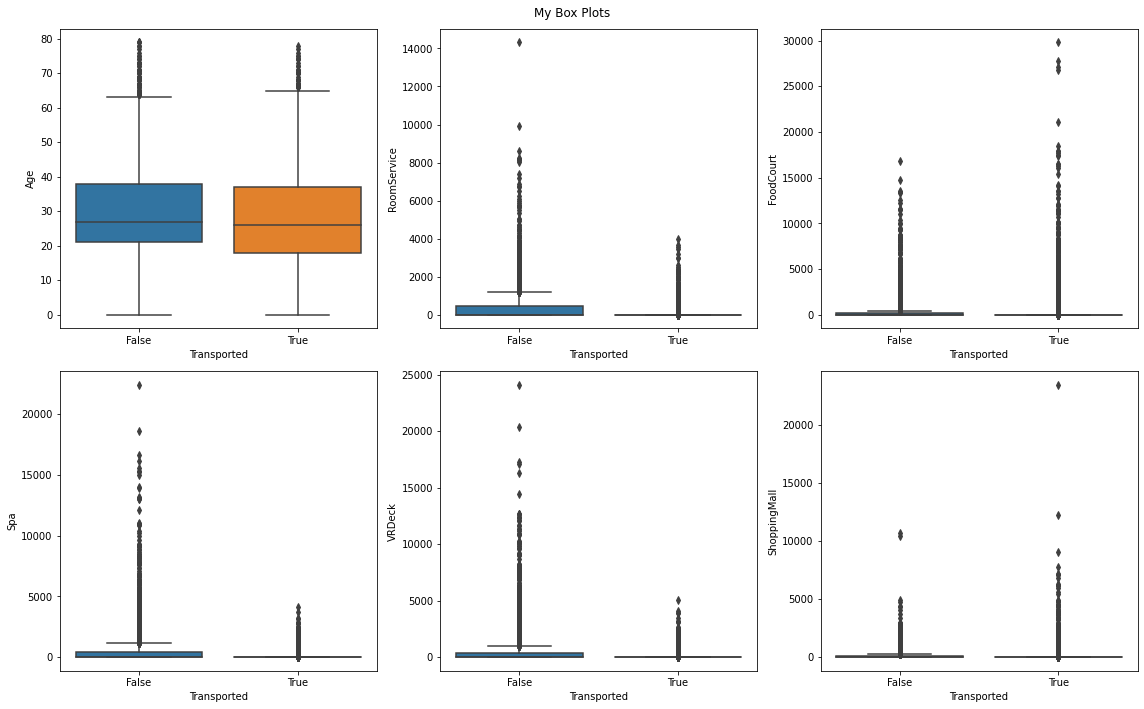

In [20]:
fig, ax = plt.subplots(2, 3, figsize=(16, 10)) # 그래프의 행과 열 지정 및, 이미지 사이즈 지정
data = train_data.copy()
# data[numeric_features.columns].columns[0:]
for i, col in enumerate(data[numeric_features.columns].columns[0:]): # 좌표 평면 지정
    # print(i, col)
    if i <= 2:
        sns.boxplot(x=data["Transported"], y=data[col], ax=ax[0,i]) # 1행 좌표 평면
    else: 
        sns.boxplot(x=data["Transported"], y=data[col], ax=ax[1,i-4]) # 5행 좌표 평면
fig.suptitle('My Box Plots')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

- 위 시각화 결과물을 놓고 보면, RoomService, FoodCount, Spa, VRDeck, ShoppingMall은 수치가 아닌 것처럼 보임. 

In [21]:
train_data['RoomService'].value_counts()

0.00       5577
1.00        117
2.00         79
3.00         61
4.00         47
           ... 
1612.00       1
2598.00       1
632.00        1
378.00        1
745.00        1
Name: RoomService, Length: 1273, dtype: int64

In [22]:
train_data['FoodCourt'].value_counts()

0.00       5456
1.00        116
2.00         75
3.00         53
4.00         53
           ... 
3846.00       1
5193.00       1
312.00        1
827.00        1
4688.00       1
Name: FoodCourt, Length: 1507, dtype: int64

In [23]:
train_data['Spa'].value_counts()

0.00       5324
1.00        146
2.00        105
5.00         53
3.00         53
           ... 
273.00        1
2581.00       1
2948.00       1
3778.00       1
1643.00       1
Name: Spa, Length: 1327, dtype: int64

- 실제 컬럼명에서 말하는 것도 다음과 같음. 
    + RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- 즉, 위 데이터는 연속형 데이터라고 보기에는 비연속형 수치 데이터인 것을 확인함. 

# Step 3. 데이터 전처리
- Feature Engineering
- ML 모형을 돌리기 위해 표준화 등 / 원핫-인코딩
- 파생변수 (도출 변수)
    + 왜 이 변수를 만들었는지에 대한 여러분들의 설명 필요

## 결측치 
- 결측치의 분포도를 확인한다.
- 결측값 분포는 훈련 데이터 세트와 테스트 데이터 세트가 유사하다.
- 관측치의 약 76%는 결측치가 없다.
- 관측치의 나머지 24%는 1~3개의 결측치가 있다.


In [24]:
test_null = pd.DataFrame(test_data.isna().sum())
test_null = test_null.sort_values(by = 0 ,ascending = False)
train_null = pd.DataFrame(train_data.isna().sum())
train_null = train_null.sort_values(by = 0 ,ascending = False)[:-1]


fig = make_subplots(rows=1, 
                    cols=2,
                    column_titles = ["Train Data", "Test Data"] ,
                    x_title="Missing Values")

fig.add_trace(go.Bar(x=train_null[0],
                     y=train_null.index,
                     orientation="h",
                    marker=dict(color=[n for n in range(12)], 
                                line_color='rgb(0,0,0)' , 
                                line_width = 2,
                                coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x=test_null[0], 
                     y=test_null.index,
                     orientation="h",
                    marker=dict(color=[n for n in range(12)], 
                                line_color='rgb(0,0,0)', 
                                line_width = 2,
                                coloraxis="coloraxis")),
              1, 2)

fig.update_layout(showlegend=False, title_text="Column wise Null Value Distribution", title_x=0.5)

In [25]:
missing_train_row = train_data.isna().sum(axis=1)
missing_train_row = pd.DataFrame(missing_train_row.value_counts()/train_data.shape[0]).reset_index()
missing_test_row = test_data.isna().sum(axis=1)
missing_test_row = pd.DataFrame(missing_test_row.value_counts()/test_data.shape[0]).reset_index()
missing_train_row.columns = ['no', 'count']
missing_test_row.columns = ['no', 'count']
missing_train_row["count"] = missing_train_row["count"]*100
missing_test_row["count"] = missing_test_row["count"]*100


fig = make_subplots(rows=1, 
                    cols=2,
                    column_titles = ["Train Data", "Test Data"] ,
                    x_title="Missing Values",)

fig.add_trace(go.Bar(x=missing_train_row["no"], 
                     y=missing_train_row["count"]  ,
                    marker=dict(color=[n for n in range(4)], 
                                line_color='rgb(0,0,0)' ,
                                line_width = 3
                                ,coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x= missing_test_row["no"], 
                     y=missing_test_row["count"],
                    marker=dict(color=[n for n in range(4)], 
                                line_color='rgb(0,0,0)',
                                line_width = 3 ,
                                coloraxis="coloraxis")),
              1, 2)
fig.update_layout(showlegend=False, title_text="Row wise Null Value Distribution", title_x=0.5)

## 연속형과 범주형 데이터의 결측치 분포
- 총 데이터의 개수 : 12개
    + 연속형 : 6
    + 범주형 : 4
    + 문자형 : 2
- HomePlanet 와 Destination는 3가지 고유한 값이 있다.
- CryoSleep 와 VIP는 bool타입이다.

In [26]:
df = pd.concat([train_data[FEATURES], test_data[FEATURES]], axis=0)
text_features = ["Cabin", "Name"]
cat_features = [col for col in FEATURES if df[col].nunique() < 25 and col not in text_features ]
cont_features = [col for col in FEATURES if df[col].nunique() >= 25 and col not in text_features ]

del df
print(f'\033[94mTotal number of features: {len(FEATURES)}')
print(f'\033[94mNumber of categorical features: {len(cat_features)}')
print(f'\033[94mNumber of continuos features: {len(cont_features)}')
print(f'\033[94mNumber of text features: {len(text_features)}')

labels=['Categorical', 'Continuos', "Text"]
values= [len(cat_features), len(cont_features), len(text_features)]
colors = ['#DE3163', '#58D68D']

fig = go.Figure(data=[go.Pie(
    labels=labels, 
    values=values, pull=[0.1, 0, 0 ],
    marker=dict(colors=colors, 
                line=dict(color='#000000', 
                          width=2))
)])
fig.show()

Total number of features: 12
Number of categorical features: 4
Number of continuos features: 6
Number of text features: 2


## 연속형 데이터의 결측치 분포
- 연령 분포

In [27]:
train_age = train_data.copy()
test_age = test_data.copy()
train_age["type"] = "Train"
test_age["type"] = "Test"
ageDf = pd.concat([train_age, test_age])
fig = px.histogram(data_frame = ageDf, 
                   x="Age",
                   color= "type",
                   color_discrete_sequence =  ['#58D68D','#DE3163'],
                   marginal="box",
                   nbins= 100,
                    template="plotly_white"
                )
fig.update_layout(title = "Distribution of Age" , title_x = 0.5)
fig.show()

## 범주형 데이터의 결측치 분포

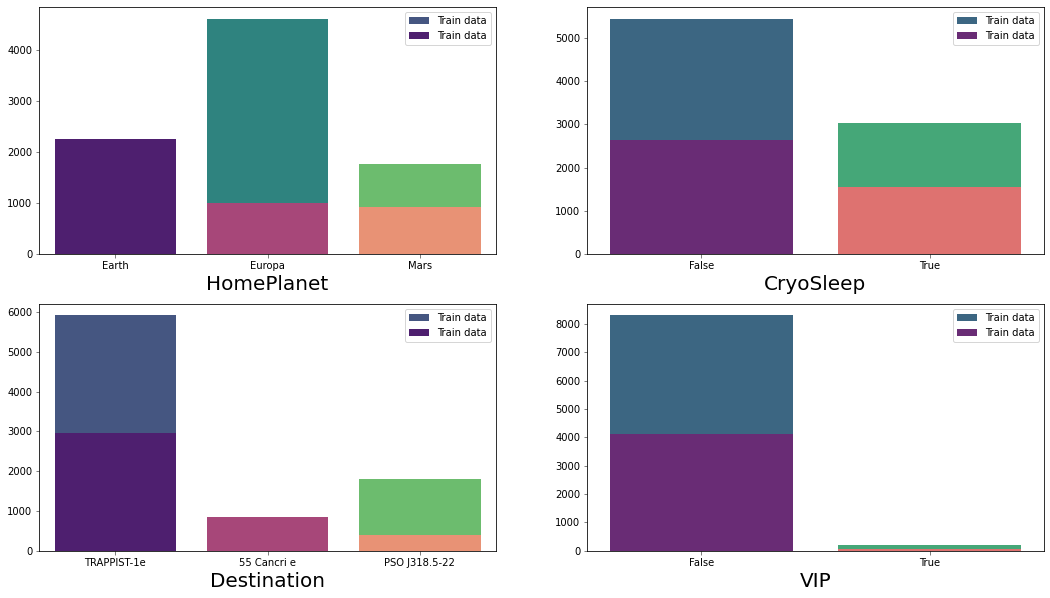

In [28]:
if len(cat_features) == 0 :
    print("No Categorical features")
else:
    ncols = 2
    nrows = 2

    fig, axes = plt.subplots(nrows, ncols, figsize=(18, 10))
    for r in range(nrows):
        for c in range(ncols):
            col = cat_features[r*ncols+c]
            sns.countplot(train_data[col],ax = axes[r,c] ,palette = "viridis", label='Train data')
            sns.countplot(test_data[col],ax = axes[r,c] ,palette = "magma", label='Train data')
            axes[r,c].legend()
            axes[r,c].set_ylabel('')
            axes[r,c].set_xlabel(col, fontsize=20)
            axes[r,c].tick_params(labelsize=10, width=0.5)
            axes[r,c].xaxis.offsetText.set_fontsize(4)
            axes[r,c].yaxis.offsetText.set_fontsize(4)
    plt.show()

## Target Distribution 
- True와 False 두 가지의 값
- 두 가지의 값은 균등하게 분포되어 있음

In [29]:
target_df = pd.DataFrame(train_data[TARGET].value_counts()).reset_index()
target_df.columns = [TARGET, 'count']
fig = px.bar(data_frame =target_df, 
             x = TARGET,
             y = 'count'
            ) 
fig.update_traces(marker_color =['#58D68D','#DE3163'], 
                  marker_line_color='rgb(0,0,0)',
                  marker_line_width=2,)
fig.update_layout(title = "Target Distribution",
                  template = "plotly_white",
                  title_x = 0.5)
print("\033[94mPercentage of Transported = 0: {:.2f} %".format(target_df["count"][0] *100 / train_data.shape[0]))
print("\033[94mPercentage of Transported = 1: {:.2f} %".format(target_df["count"][1]* 100 / train_data.shape[0]))
fig.show()

Percentage of Transported = 0: 50.36 %
Percentage of Transported = 1: 49.64 %


## 상관관계 시각화

In [30]:
fig = px.imshow(train_data.corr() ,text_auto=True, aspect="auto" , color_continuous_scale = "viridis")
fig.show()

## 불필요한 변수 제거
- 모형에 쓰지 않을 변수들을 제거한다.
- PassengerId, Name, Cabin 데이터 제거
- Name은 모형을 개선할 때, 가족 유무 등 판단 시, 재활용할 가치는 있다.
- Cabin 역시 모형 개선 시, 문자열 처리를 통해 추가 변수를 도출 할 수는 있지만, 일단은 제거한다.
- PassengerId는 따로 빼두었다.
- 컬럼값이 줄어들었다.

In [31]:
remove_cols = ['Name', 'Cabin']
# PassengerId = test_data['PassengerId']

print("Before:", train_data.shape, test_data.shape)
train_data = train_data.drop(remove_cols, axis=1)
test_data = test_data.drop(remove_cols, axis=1)

print("After:", train_data.shape, test_data.shape)

Before: (8693, 13) (4277, 12)
After: (8693, 11) (4277, 10)


## 결측치 채우기
- 결측치를 처리하기 위해 가장 쉬운 방법은 sklearn.impute 내에서의 SimpleImputer 클래스를 활용하는 것이다. 
    + https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
- train_data의 결측치 패턴을 파악한 후, train_data 및 test_data 결과에도 적용한다. 
    + 주의 : 반드시 이렇게 해야 한다. (Data Leakage 방지)
- 수치형 데이터는 평균값으로 결측치 처리

In [32]:
from sklearn.impute import SimpleImputer

imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
STRATEGY = 'median'

imputer = SimpleImputer(strategy=STRATEGY)
imputer.fit(train_data[imputer_cols])
train_data[imputer_cols] = imputer.transform(train_data[imputer_cols])
test_data[imputer_cols] = imputer.transform(test_data[imputer_cols])

print("train_data:\n", train_data.isnull().sum())
print("---")
print("test_data:\n", test_data.isnull().sum())

train_data:
 HomePlanet      201
CryoSleep       217
Destination     182
Age               0
VIP             203
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Transported       0
dtype: int64
---
test_data:
 HomePlanet      87
CryoSleep       93
Destination     92
Age              0
VIP             93
RoomService      0
FoodCourt        0
ShoppingMall     0
Spa              0
VRDeck           0
dtype: int64


- 이번에는 문자열 데이터를 추가한다. 
- 문자열 데이터는 최빈값으로 결측치 처리


In [33]:
imputer_cols = ["HomePlanet", "CryoSleep",  "Destination", "VIP"]
STRATEGY = 'most_frequent'

imputer = SimpleImputer(strategy=STRATEGY)
imputer.fit(train_data[imputer_cols])
train_data[imputer_cols] = imputer.transform(train_data[imputer_cols])
test_data[imputer_cols] = imputer.transform(test_data[imputer_cols])

print("train_data:\n", train_data.isnull().sum())
print("---")
print("test_data:\n", test_data.isnull().sum())

train_data:
 HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64
---
test_data:
 HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64


- 결측치가 사라진 것을 확인할 수 있다. 

## Categorical Feature Encoding
- 머신러닝 알고리즘은 수식으로 구성이 되어 있기 때문에 문자열의 경우 인코딩으로 변환을 주어야 한다. 
- 크게 두가지 방법이 존재한다. 
    + Ordinal Encoding 
        - 점수 : 0.78770
    + Onehot Encoding
        - 점수 : 0.78840
    + pd.get_dummies
        - 점수 : 0.78840
        
- 크게 두가지 결론을 얻을 수 있었음
    + 첫째, 본 데이터에서는 OneHotEncoding 방식이 Ordinal Encoding 보다 좋았음. 
    + 둘째, Onehot Encoding 방식과 pd.get_dummies 방식 차이는 없었음

In [34]:
'''
from sklearn.preprocessing import OrdinalEncoder

# Target 데이터는 1과 0으로 바꿈
train_data['Transported'] = train_data['Transported'].map({True: 1, False: 0})
categorical_cols = ["HomePlanet", "CryoSleep", "Destination", "VIP"]

ordinal_encoder = OrdinalEncoder()
train_data[categorical_cols] = ordinal_encoder.fit_transform(train_data[categorical_cols])
test_data[categorical_cols] = ordinal_encoder.fit_transform(test_data[categorical_cols])

train_data.info()
'''

'\nfrom sklearn.preprocessing import OrdinalEncoder\n\n# Target 데이터는 1과 0으로 바꿈\ntrain_data[\'Transported\'] = train_data[\'Transported\'].map({True: 1, False: 0})\ncategorical_cols = ["HomePlanet", "CryoSleep", "Destination", "VIP"]\n\nordinal_encoder = OrdinalEncoder()\ntrain_data[categorical_cols] = ordinal_encoder.fit_transform(train_data[categorical_cols])\ntest_data[categorical_cols] = ordinal_encoder.fit_transform(test_data[categorical_cols])\n\ntrain_data.info()\n'

- 이번에는 Onehot Encoding을 적용해본다. 이 때, pd.get_dummies() 방식을 사용한다. 

In [35]:

'''
# Target 데이터는 1과 0으로 바꿈
train_data['Transported'] = train_data['Transported'].map({True: 1, False: 0})
categorical_cols = ["HomePlanet", "CryoSleep", "Destination", "VIP"]

train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)
train_data.info()
'''

'\n# Target 데이터는 1과 0으로 바꿈\ntrain_data[\'Transported\'] = train_data[\'Transported\'].map({True: 1, False: 0})\ncategorical_cols = ["HomePlanet", "CryoSleep", "Destination", "VIP"]\n\ntrain_data = pd.get_dummies(train_data)\ntest_data = pd.get_dummies(test_data)\ntrain_data.info()\n'

- 이번에는 OneHotEncoder 메서드를 사용해본다. 

In [36]:

'''
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

# Target 데이터는 1과 0으로 바꿈
train_data['Transported'] = train_data['Transported'].map({True: 1, False: 0})
categorical_cols = ["HomePlanet", "CryoSleep", "Destination", "VIP"]

transformer = make_column_transformer(
    (OneHotEncoder(), categorical_cols),
    remainder='passthrough')

train_transformed = transformer.fit_transform(train_data[categorical_cols])
train_transformed_df = pd.DataFrame(train_transformed, columns=transformer.get_feature_names_out())
train_data = pd.concat([train_data, train_transformed_df], axis = 1)
train_data = train_data.drop(categorical_cols, axis = 1)

test_transformed = transformer.fit_transform(test_data[categorical_cols])
test_transformed_df = pd.DataFrame(test_transformed, columns=transformer.get_feature_names_out())
test_data = pd.concat([test_data, test_transformed_df], axis = 1)
test_data = test_data.drop(categorical_cols, axis = 1)
'''


'\nfrom sklearn.preprocessing import OneHotEncoder\nfrom sklearn.compose import make_column_transformer\n\n# Target 데이터는 1과 0으로 바꿈\ntrain_data[\'Transported\'] = train_data[\'Transported\'].map({True: 1, False: 0})\ncategorical_cols = ["HomePlanet", "CryoSleep", "Destination", "VIP"]\n\ntransformer = make_column_transformer(\n    (OneHotEncoder(), categorical_cols),\n    remainder=\'passthrough\')\n\ntrain_transformed = transformer.fit_transform(train_data[categorical_cols])\ntrain_transformed_df = pd.DataFrame(train_transformed, columns=transformer.get_feature_names_out())\ntrain_data = pd.concat([train_data, train_transformed_df], axis = 1)\ntrain_data = train_data.drop(categorical_cols, axis = 1)\n\ntest_transformed = transformer.fit_transform(test_data[categorical_cols])\ntest_transformed_df = pd.DataFrame(test_transformed, columns=transformer.get_feature_names_out())\ntest_data = pd.concat([test_data, test_transformed_df], axis = 1)\ntest_data = test_data.drop(categorical_cols, ax

In [37]:
label_cols = ["HomePlanet", "CryoSleep","Destination" ,"VIP"]
def label_encoder(train,test,columns):
    for col in columns:
        train_data[col] = train_data[col].astype(str)
        test_data[col] = test_data[col].astype(str)
        train_data[col] = LabelEncoder().fit_transform(train[col])
        test_data[col] =  LabelEncoder().fit_transform(test[col])
    return train, test

train_data ,test_data = label_encoder(train_data, test_data, label_cols)

In [38]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   int64  
 1   CryoSleep     8693 non-null   int64  
 2   Destination   8693 non-null   int64  
 3   Age           8693 non-null   float64
 4   VIP           8693 non-null   int64  
 5   RoomService   8693 non-null   float64
 6   FoodCourt     8693 non-null   float64
 7   ShoppingMall  8693 non-null   float64
 8   Spa           8693 non-null   float64
 9   VRDeck        8693 non-null   float64
 10  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), int64(4)
memory usage: 687.8 KB


In [39]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    4277 non-null   int64  
 1   CryoSleep     4277 non-null   int64  
 2   Destination   4277 non-null   int64  
 3   Age           4277 non-null   float64
 4   VIP           4277 non-null   int64  
 5   RoomService   4277 non-null   float64
 6   FoodCourt     4277 non-null   float64
 7   ShoppingMall  4277 non-null   float64
 8   Spa           4277 non-null   float64
 9   VRDeck        4277 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 334.3 KB


# Step 4. 머신러닝 모형 개발
- 모형에 대한 설명 필요
- 모형을 1-2개 사용
- 교차 검증
- 하이퍼파라미터 튜닝

- 독립변수와 종속변수를 구분해야 한다. 

In [40]:
X_cols = test_data.columns
X = train_data[X_cols].to_numpy()
y = train_data['Transported'].to_numpy()

- 이번에는 훈련데이터를 검증데이터를 분리한다. 
- 이때 교차검증은 3회만 실시한다. 

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((6085, 10), (2608, 10), (6085,), (2608,))

- 이번에는 LightGBM 클래스를 부른 후 모형을 학습한다. 

# 하이퍼파라미터 튜닝
- 랜덤서치 (매개변수, max_depth)
- 그리드서치

In [42]:
'''
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=42)
lgb
'''

'\nfrom lightgbm import LGBMClassifier\n\nlgb = LGBMClassifier(random_state=42)\nlgb\n'

# Model Selection 
- Ref. https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide
- 그리드 서치를 적용함. 
- 4차시도 : 0.79097 (미 적용 시 : 0.78840)
    + 큰 차이는 일어나지 않음
    + 그러나 코드는 많이 작성...;;;

## 모형 옵션 선택
- 아래와 같은 모형을 정의한다. 

In [43]:
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

# Classifiers
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0),
    "KNN" : KNeighborsClassifier(),
    "RandomForest" : RandomForestClassifier(random_state=0),
    "LGBM" : LGBMClassifier(random_state=0)
}

- 그리드 서치를 위한 옵션을 선택한다. 

In [44]:
# Grids for grid search
LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [4, 6, 8, 10, 12]}

boosted_grid = {'n_estimators': [50, 100, 150, 200],
        'max_depth': [4, 8, 12],
        'learning_rate': [0.05, 0.1, 0.15]}

# Dictionary of all grids
grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
    "RandomForest" : RF_grid,
    "LGBM" : boosted_grid
}

- 불러온 모형과 그리드 서치를 각각 개별적으로 정의하는 코드를 작성한다. 
- 해당 결과는 모두 데이터프레임에 담도록 한다. 

In [45]:
# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
import time

i=0
clf_best_params=classifiers.copy()
valid_scores=pd.DataFrame({'Classifer':classifiers.keys(), 'Validation accuracy': np.zeros(len(classifiers)), 'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    # Train and score
    clf.fit(X_train, y_train)
    valid_scores.iloc[i,1]=clf.score(X_val, y_val)

    # Save trained model
    clf_best_params[key]=clf.best_params_
    
    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,2]=np.round((stop - start)/60, 2)
    
    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,2])
    print('')
    i+=1

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS 

Model: LogisticRegression
Training time (mins): 0.05

Model: KNN
Training time (mins): 0.03

Model: RandomForest
Training time (mins): 0.69

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad si

- 4개의 모형에 대한 모형 개발 속도 및 정확도 평가지표를 확인한다. 

In [46]:
# Show results
valid_scores

,Classifer,Validation accuracy,Training time
0,LogisticRegression,0.77,0.05
1,KNN,0.78,0.03
2,RandomForest,0.79,0.69
3,LGBM,0.79,0.18


- 그리드 서치를 통해서 얻어낸 지표 중 가장 좋은 파라미터를 찾는다. 

In [47]:
clf_best_params

{'LogisticRegression': {'C': 0.5, 'max_iter': 150, 'penalty': 'l2'},
 'KNN': {'n_neighbors': 9, 'p': 2},
 'RandomForest': {'max_depth': 8, 'n_estimators': 100},
 'LGBM': {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}}

- 가장 좋은 모형을 적용한다. 

In [48]:
# Classifiers
best_classifiers = {
    "RandomForest" : RandomForestClassifier(**clf_best_params["RandomForest"], random_state=0),
    "LGBM" : LGBMClassifier(**clf_best_params["LGBM"], random_state=0)
}

- 이번에는 10겹 교차검증을 실시한다. 

In [49]:
# Number of folds in cross validation
FOLDS=10

preds=np.zeros(len(test_data))
for key, classifier in best_classifiers.items():
    start = time.time()
    
    # 5-fold cross validation
    cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=0)
    
    score=0
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        # Get training and validation sets
        X_train, X_valid = X[train_idx], X[val_idx]
        y_train, y_valid = y[train_idx], y[val_idx]

        # Train model
        clf = classifier
        clf.fit(X_train, y_train)

        # Make predictions and measure accuracy
        preds += clf.predict_proba(test_data)[:,1]
        score += clf.score(X_valid, y_valid)

    # Average accuracy    
    score=score/FOLDS
    
    # Stop timer
    stop = time.time()

    # Print accuracy and time
    print('Model:', key)
    print('Average validation accuracy:', np.round(100*score,2))
    print('Training time (mins):', np.round((stop - start)/60,2))
    print('')
    
# Ensemble predictions
preds=preds/(FOLDS*len(best_classifiers))

Model: RandomForest
Average validation accuracy: 79.49
Training time (mins): 0.12

Model: LGBM
Average validation accuracy: 79.47
Training time (mins): 0.03



# Step 5. 모형 평가
- 훈련데이터 쪼갠다. 훈련데이터 + 검증데이터 분리
- 정확도 비교
- 혼동행렬 (Confusion Matrix) 설명

- 먼저 cross_validate() 활용한다. 

In [50]:
"""
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

splitter = StratifiedKFold(n_splits = 5, shuffle = True, random_state=42)
scores = cross_validate(lgb, X_train, y_train, return_train_score = True, cv=splitter)

print("train Acc.", np.mean(scores['train_score']))
print("test Acc.", np.mean(scores['test_score']))
"""

'\nfrom sklearn.model_selection import StratifiedKFold\nfrom sklearn.model_selection import cross_validate\n\nsplitter = StratifiedKFold(n_splits = 5, shuffle = True, random_state=42)\nscores = cross_validate(lgb, X_train, y_train, return_train_score = True, cv=splitter)\n\nprint("train Acc.", np.mean(scores[\'train_score\']))\nprint("test Acc.", np.mean(scores[\'test_score\']))\n'

- 이번에는 검증 데이터를 활용하여 정확도를 예상해본다. 

In [51]:
"""
from sklearn.metrics import accuracy_score

lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_val)
print("Acc.", accuracy_score(y_val, y_pred))
"""

'\nfrom sklearn.metrics import accuracy_score\n\nlgb.fit(X_train, y_train)\ny_pred = lgb.predict(X_val)\nprint("Acc.", accuracy_score(y_val, y_pred))\n'

# Step 6. 제출

In [52]:
"""
test_preds = lgb.predict(test_data.to_numpy())
sample_submission['Transported'] = test_preds.astype("bool")
sample_submission.to_csv("submission.csv",index=False)
sample_submission.head()
"""

# Round predictions to nearest integer
preds=np.round(preds).astype(bool)
sample_submission['Transported'] = preds
sample_submission.to_csv("submission.csv",index=False)
sample_submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


# 참고
- Sanskar Hasija, 🚀Spaceship Titanic -📊EDA + 27 different models📈
    + https://www.kaggle.com/code/odins0n/spaceship-titanic-eda-27-different-models